C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10900\190309157.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("stocks.csv", dtype={


Epoch 1/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 154307856.0000 - val_loss: 241032960.0000
Epoch 2/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 151046416.0000 - val_loss: 241821168.0000
Epoch 3/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 148879040.0000 - val_loss: 241175728.0000
Epoch 4/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 149047168.0000 - val_loss: 240035856.0000
Epoch 5/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 150582080.0000 - val_loss: 240643184.0000
Epoch 6/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 149183728.0000 - val_loss: 240092816.0000
Epoch 7/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 149327520.0000 - val_loss: 239908656.0000
Epoch 8/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 149666144.0000 - val_loss: 241005136.0000
Epoch 9/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 152272224.0000 - val_loss: 240797824.0000
Epoch 10/32
5724/5724 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step

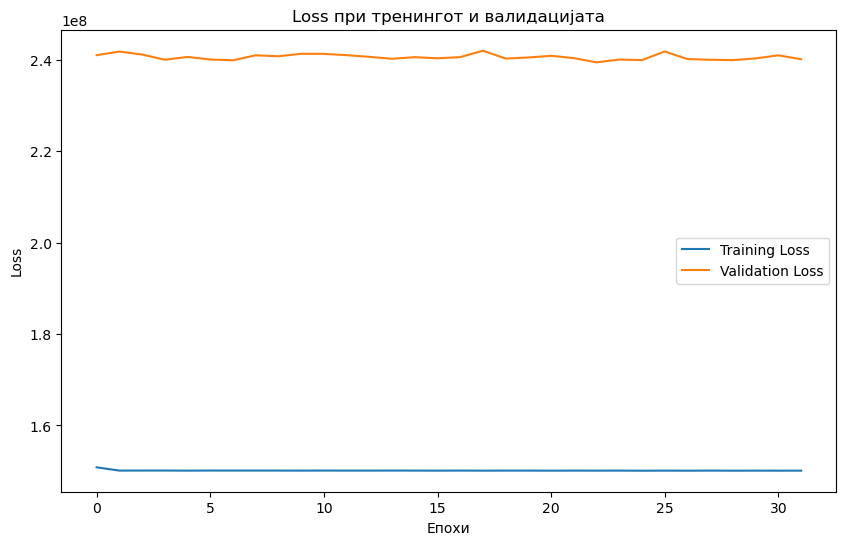

3067/3067 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Mean Squared Error: 219150320.03
Mean Absolute Error: 7349.97
R2 Score: -0.00


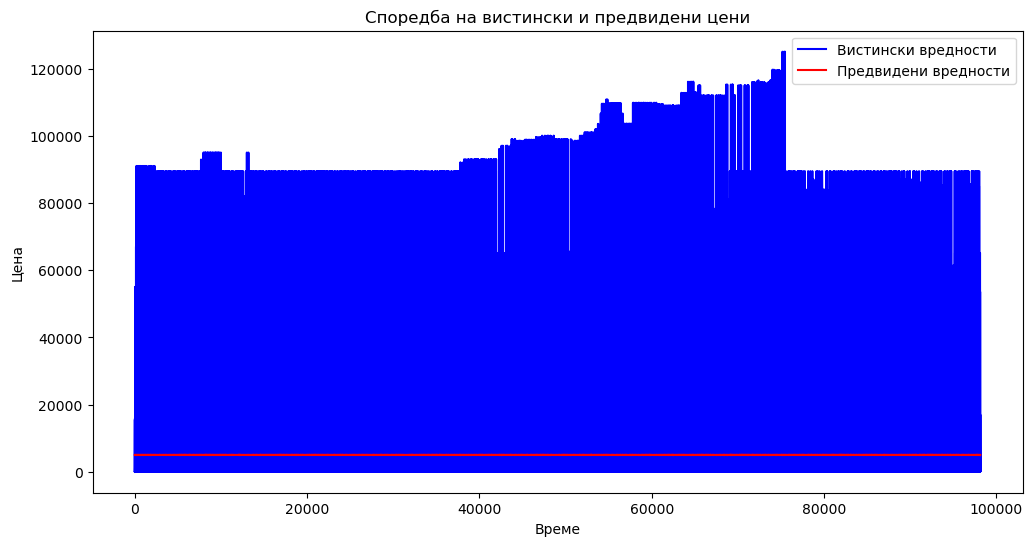

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from keras.models import load_model
import joblib  


df = pd.read_csv("stocks.csv", dtype={
    'open_price': 'str', 'high_price': 'str', 'low_price': 'str', 'close_price': 'str'
})


for col in ['open_price', 'high_price', 'low_price', 'close_price']:
    df[col] = df[col].str.replace('.', '').str.replace(',', '.').astype(float) / 100

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)
df = df[['close_price']].copy()


lag = 3
for i in range(1, lag + 1):
    df[f"close_price_{i}"] = df["close_price"].shift(i)
df.dropna(inplace=True)


X = df.drop(columns=["close_price"])
y = df["close_price"]


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, shuffle=False)


scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)


train_X = train_X.reshape(train_X.shape[0], lag, 1)
test_X = test_X.reshape(test_X.shape[0], lag, 1)


model = Sequential([
    Input(shape=(lag, 1)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])


model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(train_X, train_y, validation_split=0.2, epochs=32, batch_size=32, verbose=1)


plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history['loss'], label='Training Loss')
sns.lineplot(data=history.history['val_loss'], label='Validation Loss')
plt.title("Loss при тренингот и валидацијата")
plt.xlabel("Епохи")
plt.ylabel("Loss")
plt.legend()
plt.show()


pred_y = model.predict(test_X)


mse = mean_squared_error(test_y, pred_y)
mae = mean_absolute_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


plt.figure(figsize=(12, 6))
plt.plot(test_y.values, label="Вистински вредности", color="blue")
plt.plot(pred_y, label="Предвидени вредности", color="red")
plt.title("Споредба на вистински и предвидени цени")
plt.xlabel("Време")
plt.ylabel("Цена")
plt.legend()
plt.show()


model.save("lstm_model.h5")


joblib.dump(scaler, "scaler.pkl")

np.save("predictions.npy", pred_y)
test_y.to_csv("test_data.csv")
